# Описание задания

**Цель лабораторной работы:** изучение способов предварительной обработки данных для дальнейшего формирования моделей.

**Задание:**

1. Выбрать набор данных (датасет), содержащий категориальные признаки и пропуски в данных. Для выполнения следующих пунктов можно использовать несколько различных наборов данных (один для обработки пропусков, другой для категориальных признаков и т.д.)

2. Для выбранного датасета (датасетов) на основе материалов лекции решить следующие задачи:

* обработку пропусков в данных;

* кодирование категориальных признаков;

* масштабирование данных.

# Ход выполнения лабораторной работы

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

In [0]:
# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "title='dc-wikia-data.csv'"}).GetList()

In [0]:
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: dc-wikia-data.csv, id: 1mp_Y-6OLZLTtpzYI8UA7-_EulThJZK-o
downloading to /root/data/dc-wikia-data.csv


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [0]:
data = pd.read_csv(fname, sep=",")

In [0]:
data.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR
0,1422,Batman (Bruce Wayne),\/wiki\/Batman_(Bruce_Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3093.0,"1939, May",1939.0
1,23387,Superman (Clark Kent),\/wiki\/Superman_(Clark_Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2496.0,"1986, October",1986.0
2,1458,Green Lantern (Hal Jordan),\/wiki\/Green_Lantern_(Hal_Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,NaN,Living Characters,1565.0,"1959, October",1959.0
3,1659,James Gordon (New Earth),\/wiki\/James_Gordon_(New_Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,NaN,Living Characters,1316.0,"1987, February",1987.0
4,1576,Richard Grayson (New Earth),\/wiki\/Richard_Grayson_(New_Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,1237.0,"1940, April",1940.0


In [0]:
data.shape

(6896, 13)

In [0]:
data.dtypes

page_id               int64
name                 object
urlslug              object
ID                   object
ALIGN                object
EYE                  object
HAIR                 object
SEX                  object
GSM                  object
ALIVE                object
APPEARANCES         float64
FIRST APPEARANCE     object
YEAR                float64
dtype: object

In [0]:
data.isnull().sum()

page_id                0
name                   0
urlslug                0
ID                  2013
ALIGN                601
EYE                 3628
HAIR                2274
SEX                  125
GSM                 6832
ALIVE                  3
APPEARANCES          355
FIRST APPEARANCE      69
YEAR                  69
dtype: int64

## Удаление 

In [0]:
# Удаление колонок
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)

((6896, 13), (6896, 3))

In [0]:
# Удаление строк
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((6896, 13), (38, 13))

## Заполнение нулями

In [0]:
# Заполнение всех пропущенных значений нулями
data_new_3 = data.fillna(0)
data_new_3.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR
0,1422,Batman (Bruce Wayne),\/wiki\/Batman_(Bruce_Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,0,Living Characters,3093.0,"1939, May",1939.0
1,23387,Superman (Clark Kent),\/wiki\/Superman_(Clark_Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,0,Living Characters,2496.0,"1986, October",1986.0
2,1458,Green Lantern (Hal Jordan),\/wiki\/Green_Lantern_(Hal_Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,0,Living Characters,1565.0,"1959, October",1959.0
3,1659,James Gordon (New Earth),\/wiki\/James_Gordon_(New_Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,0,Living Characters,1316.0,"1987, February",1987.0
4,1576,Richard Grayson (New Earth),\/wiki\/Richard_Grayson_(New_Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,0,Living Characters,1237.0,"1940, April",1940.0


## Внедрение значений (числовые данные)

In [0]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
total_count = data.shape[0]
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'
              .format(col, dt, temp_null_count, temp_perc))

Колонка APPEARANCES. Тип данных float64. Количество пустых значений 355, 5.15%.
Колонка YEAR. Тип данных float64. Количество пустых значений 69, 1.0%.


In [0]:
data_num = data[num_cols]
data_num

,APPEARANCES,YEAR
0,3093.0,1939.0
1,2496.0,1986.0
2,1565.0,1959.0
3,1316.0,1987.0
4,1237.0,1940.0
5,1231.0,1941.0
6,1121.0,1941.0
7,1095.0,1989.0
8,1075.0,1969.0
9,1028.0,1956.0


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


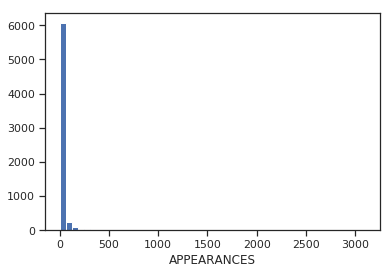

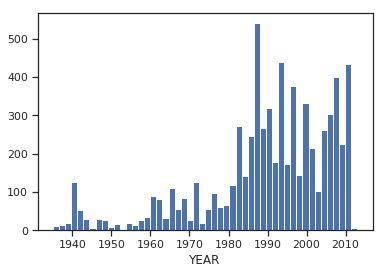

In [0]:
# Гистограмма по признакам
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

In [0]:
# Фильтр по пустым значениям поля YEAR 
data[data['YEAR'].isnull()]

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR
386,1891,Jakeem Williams (New Earth),\/wiki\/Jakeem_Williams_(New_Earth),Secret Identity,NaN,Brown Eyes,NaN,Male Characters,NaN,Living Characters,79.0,NaN,NaN
1400,64303,Hadley Jaggar (New Earth),\/wiki\/Hadley_Jaggar_(New_Earth),Secret Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,NaN,Deceased Characters,19.0,NaN,NaN
1401,13097,Nergal (New Earth),\/wiki\/Nergal_(New_Earth),NaN,Bad Characters,Yellow Eyes,NaN,Male Characters,NaN,Living Characters,19.0,NaN,NaN
1832,65286,Gregory Wolfe (New Earth),\/wiki\/Gregory_Wolfe_(New_Earth),Public Identity,Neutral Characters,Brown Eyes,Black Hair,Male Characters,NaN,Living Characters,14.0,NaN,NaN
1937,146333,Clarence Charles Batson V (New Earth),\/wiki\/Clarence_Charles_Batson_V_(New_Earth),Public Identity,Good Characters,NaN,Black Hair,Male Characters,NaN,Deceased Characters,13.0,NaN,NaN
1938,113413,Chad Graham (New Earth),\/wiki\/Chad_Graham_(New_Earth),Secret Identity,Bad Characters,NaN,Blond Hair,Male Characters,NaN,Deceased Characters,13.0,NaN,NaN
2065,344513,Jupiter (New Earth),\/wiki\/Jupiter_(New_Earth),NaN,Good Characters,NaN,White Hair,Male Characters,NaN,Living Characters,12.0,NaN,NaN
2066,344983,Pegasus (New Earth),\/wiki\/Pegasus_(New_Earth),NaN,Good Characters,NaN,Black Hair,Female Characters,NaN,Living Characters,12.0,NaN,NaN
2067,286906,Asteroth (New Earth),\/wiki\/Asteroth_(New_Earth),Secret Identity,Bad Characters,Yellow Eyes,Black Hair,Male Characters,NaN,Living Characters,12.0,NaN,NaN
2230,155569,Red Panzer IV (New Earth),\/wiki\/Red_Panzer_IV_(New_Earth),Secret Identity,Bad Characters,NaN,NaN,Male Characters,NaN,Living Characters,11.0,NaN,NaN


In [0]:
# Запоминаем индексы строк с пустыми значениями
flt_index = data[data['YEAR'].isnull()].index
flt_index

Int64Index([ 386, 1400, 1401, 1832, 1937, 1938, 2065, 2066, 2067, 2230, 2231,
            2232, 2413, 2414, 2841, 2842, 3104, 3105, 3431, 3432, 3433, 3434,
            3435, 3819, 3820, 3821, 3822, 3823, 3824, 4320, 4321, 4322, 4323,
            4826, 4827, 4828, 4829, 5525, 5526, 5527, 5528, 5529, 5530, 5531,
            5532, 5533, 5534, 5535, 5536, 5537, 5538, 6532, 6533, 6534, 6535,
            6536, 6537, 6538, 6539, 6540, 6887, 6888, 6889, 6890, 6891, 6892,
            6893, 6894, 6895],
           dtype='int64')

In [0]:
# Проверяем что выводятся нужные строки
data[data.index.isin(flt_index)]

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR
386,1891,Jakeem Williams (New Earth),\/wiki\/Jakeem_Williams_(New_Earth),Secret Identity,NaN,Brown Eyes,NaN,Male Characters,NaN,Living Characters,79.0,NaN,NaN
1400,64303,Hadley Jaggar (New Earth),\/wiki\/Hadley_Jaggar_(New_Earth),Secret Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,NaN,Deceased Characters,19.0,NaN,NaN
1401,13097,Nergal (New Earth),\/wiki\/Nergal_(New_Earth),NaN,Bad Characters,Yellow Eyes,NaN,Male Characters,NaN,Living Characters,19.0,NaN,NaN
1832,65286,Gregory Wolfe (New Earth),\/wiki\/Gregory_Wolfe_(New_Earth),Public Identity,Neutral Characters,Brown Eyes,Black Hair,Male Characters,NaN,Living Characters,14.0,NaN,NaN
1937,146333,Clarence Charles Batson V (New Earth),\/wiki\/Clarence_Charles_Batson_V_(New_Earth),Public Identity,Good Characters,NaN,Black Hair,Male Characters,NaN,Deceased Characters,13.0,NaN,NaN
1938,113413,Chad Graham (New Earth),\/wiki\/Chad_Graham_(New_Earth),Secret Identity,Bad Characters,NaN,Blond Hair,Male Characters,NaN,Deceased Characters,13.0,NaN,NaN
2065,344513,Jupiter (New Earth),\/wiki\/Jupiter_(New_Earth),NaN,Good Characters,NaN,White Hair,Male Characters,NaN,Living Characters,12.0,NaN,NaN
2066,344983,Pegasus (New Earth),\/wiki\/Pegasus_(New_Earth),NaN,Good Characters,NaN,Black Hair,Female Characters,NaN,Living Characters,12.0,NaN,NaN
2067,286906,Asteroth (New Earth),\/wiki\/Asteroth_(New_Earth),Secret Identity,Bad Characters,Yellow Eyes,Black Hair,Male Characters,NaN,Living Characters,12.0,NaN,NaN
2230,155569,Red Panzer IV (New Earth),\/wiki\/Red_Panzer_IV_(New_Earth),Secret Identity,Bad Characters,NaN,NaN,Male Characters,NaN,Living Characters,11.0,NaN,NaN


In [0]:
data_num_Year = data_num[['YEAR']]
data_num_Year.head()

,YEAR
0,1939.0
1,1986.0
2,1959.0
3,1987.0
4,1940.0


In [0]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [0]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_Year)
mask_missing_values_only

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [0]:
strategies=['mean', 'median','most_frequent']

In [0]:
def test_num_impute(strategy_param):
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(data_num_Year)
    return data_num_imp[mask_missing_values_only]

In [0]:
strategies[0], test_num_impute(strategies[0])

('mean', array([1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 1989.76666178, 1989.76666178,
        1989.76666178, 1989.76666178, 19

In [0]:
strategies[1], test_num_impute(strategies[1])

('median',
 array([1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992.,
        1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992.,
        1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992.,
        1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992.,
        1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992.,
        1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992.,
        1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992., 1992.,
        1992., 1992., 1992., 1992., 1992., 1992.]))

In [0]:
strategies[2], test_num_impute(strategies[2])

('most_frequent',
 array([2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006.,
        2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006.,
        2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006.,
        2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006.,
        2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006.,
        2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006.,
        2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006., 2006.,
        2006., 2006., 2006., 2006., 2006., 2006.]))

## Внедрение значений (категориальные данные)

In [0]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'
              .format(col, dt, temp_null_count, temp_perc))

Колонка ID. Тип данных object. Количество пустых значений 2013, 29.19%.
Колонка ALIGN. Тип данных object. Количество пустых значений 601, 8.72%.
Колонка EYE. Тип данных object. Количество пустых значений 3628, 52.61%.
Колонка HAIR. Тип данных object. Количество пустых значений 2274, 32.98%.
Колонка SEX. Тип данных object. Количество пустых значений 125, 1.81%.
Колонка GSM. Тип данных object. Количество пустых значений 6832, 99.07%.
Колонка ALIVE. Тип данных object. Количество пустых значений 3, 0.04%.
Колонка FIRST APPEARANCE. Тип данных object. Количество пустых значений 69, 1.0%.


In [0]:
cat_temp_data = data[['HAIR']]
cat_temp_data.tail(10)

,HAIR
6886,NaN
6887,NaN
6888,NaN
6889,Grey Hair
6890,NaN
6891,NaN
6892,NaN
6893,NaN
6894,NaN
6895,Blond Hair


In [0]:
cat_temp_data['HAIR'].unique()

array(['Black Hair', 'Brown Hair', 'White Hair', 'Blond Hair', 'Red Hair',
       nan, 'Green Hair', 'Strawberry Blond Hair', 'Grey Hair',
       'Silver Hair', 'Orange Hair', 'Purple Hair', 'Gold Hair',
       'Blue Hair', 'Reddish Brown Hair', 'Pink Hair', 'Violet Hair',
       'Platinum Blond Hair'], dtype=object)

In [0]:
cat_temp_data[cat_temp_data['HAIR'].isnull()].shape

(2274, 1)

In [0]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['Black Hair'],
       ['Black Hair'],
       ['Brown Hair'],
       ...,
       ['Black Hair'],
       ['Black Hair'],
       ['Blond Hair']], dtype=object)

In [0]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['Black Hair', 'Blond Hair', 'Blue Hair', 'Brown Hair', 'Gold Hair',
       'Green Hair', 'Grey Hair', 'Orange Hair', 'Pink Hair',
       'Platinum Blond Hair', 'Purple Hair', 'Red Hair',
       'Reddish Brown Hair', 'Silver Hair', 'Strawberry Blond Hair',
       'Violet Hair', 'White Hair'], dtype=object)

## Преобразование категориальных признаков в числовые

In [0]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,Black Hair
1,Black Hair
2,Brown Hair
3,White Hair
4,Black Hair
5,Black Hair
6,Blond Hair
7,Black Hair
8,Blond Hair
9,Blond Hair


### Label encoding

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [0]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [0]:
cat_enc['c1'].unique()

array(['Black Hair', 'Brown Hair', 'White Hair', 'Blond Hair', 'Red Hair',
       'Green Hair', 'Strawberry Blond Hair', 'Grey Hair', 'Silver Hair',
       'Orange Hair', 'Purple Hair', 'Gold Hair', 'Blue Hair',
       'Reddish Brown Hair', 'Pink Hair', 'Violet Hair',
       'Platinum Blond Hair'], dtype=object)

In [0]:
np.unique(cat_enc_le)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [0]:
le.inverse_transform([x for x in range(16)])

array(['Black Hair', 'Blond Hair', 'Blue Hair', 'Brown Hair', 'Gold Hair',
       'Green Hair', 'Grey Hair', 'Orange Hair', 'Pink Hair',
       'Platinum Blond Hair', 'Purple Hair', 'Red Hair',
       'Reddish Brown Hair', 'Silver Hair', 'Strawberry Blond Hair',
       'Violet Hair'], dtype=object)

In [0]:
cat_enc_le

array([0, 0, 3, ..., 0, 0, 1])

### One-hot encoding

In [0]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [0]:
cat_enc.shape

(6896, 1)

In [0]:
cat_enc_ohe.shape

(6896, 17)

In [0]:
cat_enc_ohe

<6896x17 sparse matrix of type '<class 'numpy.float64'>'
	with 6896 stored elements in Compressed Sparse Row format>

In [0]:
cat_enc_ohe.todense()[0:10]

matrix([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]])

### Или

In [0]:
pd.get_dummies(cat_enc).tail()

,c1_Black Hair,c1_Blond Hair,c1_Blue Hair,c1_Brown Hair,c1_Gold Hair,c1_Green Hair,c1_Grey Hair,c1_Orange Hair,c1_Pink Hair,c1_Platinum Blond Hair,c1_Purple Hair,c1_Red Hair,c1_Reddish Brown Hair,c1_Silver Hair,c1_Strawberry Blond Hair,c1_Violet Hair,c1_White Hair
6891,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6892,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6893,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6894,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6895,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
pd.get_dummies(cat_temp_data, dummy_na=True).tail()

,HAIR_Black Hair,HAIR_Blond Hair,HAIR_Blue Hair,HAIR_Brown Hair,HAIR_Gold Hair,HAIR_Green Hair,HAIR_Grey Hair,HAIR_Orange Hair,HAIR_Pink Hair,HAIR_Platinum Blond Hair,HAIR_Purple Hair,HAIR_Red Hair,HAIR_Reddish Brown Hair,HAIR_Silver Hair,HAIR_Strawberry Blond Hair,HAIR_Violet Hair,HAIR_White Hair,HAIR_nan
6891,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6892,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6893,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6894,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6895,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Масштабирование данных

In [0]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

### MinMax масштабирование

In [0]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data_new_2[['APPEARANCES']])

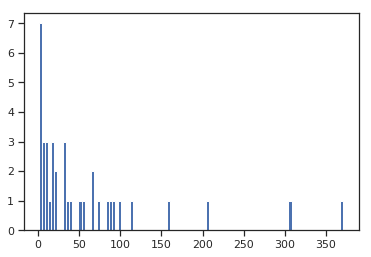

In [0]:
plt.hist(data_new_2['APPEARANCES'], 100)
plt.show()

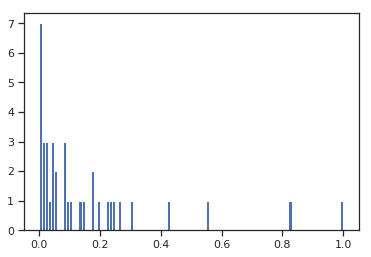

In [0]:
plt.hist(sc1_data, 100)
plt.show()

In [0]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data_new_2[['APPEARANCES']])

### Z-оценка

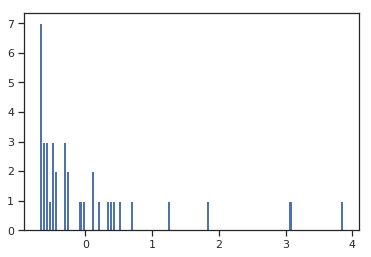

In [0]:
plt.hist(sc2_data, 100)
plt.show()

### Нормализация данных

In [0]:
sc3 = Normalizer()
sc3_data = sc3.fit_transform(data_new_2[['APPEARANCES']])

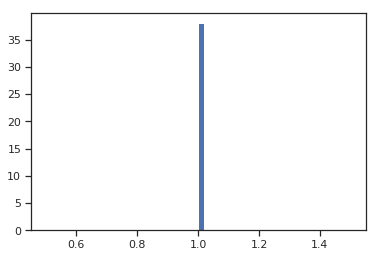

In [0]:
plt.hist(sc3_data, 50)
plt.show()